## Download dataset

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip 'drive/MyDrive/emg_imu_data.zip'


In [1]:
# 导入包
from c2net.context import prepare, upload_output

# 初始化导入数据集和预训练模型到容器内
c2net_context = prepare()


       ___                _            _            _          
      |__ \              | |          | |          | |         
  ___    ) | _ __    ___ | |_  ______ | |__    ___ | |_   __ _ 
 / __|  / / | '_ \  / _ \| __||______|| '_ \  / _ \| __| / _` |
| (__  / /_ | | | ||  __/| |_         | |_) ||  __/| |_ | (_| |
 \___||____||_| |_| \___| \__|        |_.__/  \___| \__| \__,_|
                                                               
         

If you have any problems while preparing the data, you can submit an issue in this repository: https://openi.pcl.ac.cn/OpenIOSSG/c2net-pypi
        
Detected .code_cache_file already exists, code has been prepared!
Detected .dataset_cache_file already exists, dataset has been prepared!
please set c2net_context.output_path as the output location


In [2]:
datasetPath = c2net_context.dataset_path
datasetPath

'/tmp/dataset'

In [3]:
# 获取数据集路径
imu_data_path = c2net_context.dataset_path + "/" + "imu_data"
emg_data_path = c2net_context.dataset_path + "/" + "emg_data"

# 输出结果必须保存在该目录
you_should_save_here = c2net_context.output_path

In [14]:
you_should_save_here

'/tmp/output'

In [4]:
imu_data_path = c2net_context.dataset_path + "/" + "imu_data" + "/" + "imu_data"
emg_data_path = c2net_context.dataset_path + "/" + "emg_data" + "/" + "emg_data"

## 配置环境

In [ ]:
# !pip install scikit-learn
!pip install scikit-learn -i http://mirrors.aliyun.com/pypi/simple/ --trusted-host mirrors.aliyun.com

## Fix Random Seed

In [5]:
import numpy as np
import torch
import random


def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


# set_seed(87)
set_seed(123)

# Data

## Dataset

In [6]:
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os


class FusedDataset(Dataset):
    def __init__(
        self, emg_directory, imu_directory, emg_seq_length=790, imu_seq_length=205
    ):
        self.emg_seq_length = emg_seq_length
        self.imu_seq_length = imu_seq_length
        self.emg_files = []
        self.imu_files = []
        self.labels = []

        # Load EMG and IMU files into dictionaries with full filenames (minus extension) as keys
        emg_files = {
            f[:-8]: os.path.join(emg_directory, f)
            for f in os.listdir(emg_directory)
            if f.endswith("_emg.txt")
        }
        imu_files = {
            f[:-8]: os.path.join(imu_directory, f)
            for f in os.listdir(imu_directory)
            if f.endswith("_imu.txt")
        }

        # Match EMG and IMU files based on the same label (derived from full filenames)
        for file_key in emg_files:
            if file_key in imu_files:
                emg_filepath = emg_files[file_key]
                imu_filepath = imu_files[file_key]
                if (
                    os.path.getsize(emg_filepath) > 0
                    and os.path.getsize(imu_filepath) > 0
                ):
                    self.emg_files.append(emg_filepath)
                    self.imu_files.append(imu_filepath)
                    self.labels.append(file_key.split("_")[0])

        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)
        self.labels = torch.from_numpy(self.labels).long()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        emg_path = self.emg_files[idx]
        imu_path = self.imu_files[idx]
        emg_signals = self.load_and_process_data(emg_path, self.emg_seq_length)
        imu_signals = self.load_and_process_data(imu_path, self.imu_seq_length)

        return emg_signals, imu_signals, self.labels[idx]

    def load_and_process_data(self, filepath, seq_length):
        data = np.loadtxt(filepath)
        if data.shape[0] < seq_length:
            data = np.vstack(
                [data, np.zeros((seq_length - data.shape[0], data.shape[1]))]
            )
        elif data.shape[0] > seq_length:
            data = data[:seq_length, :]
        return torch.from_numpy(data).float()

    def get_num_classes(self):
        return len(np.unique(self.labels))

In [16]:
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os


class EMGOnlyDataset(Dataset):
    def __init__(self, emg_directory, emg_seq_length=790):
        self.emg_seq_length = emg_seq_length
        self.emg_files = []
        self.labels = []

        # Load EMG files into a list
        emg_files = {
            f[:-8]: os.path.join(emg_directory, f)
            for f in os.listdir(emg_directory)
            if f.endswith("_emg.txt")
        }

        # Collect EMG files and their corresponding labels
        for file_key, emg_filepath in emg_files.items():
            if os.path.getsize(emg_filepath) > 0:
                self.emg_files.append(emg_filepath)
                self.labels.append(file_key.split("_")[0])

        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)
        self.labels = torch.from_numpy(self.labels).long()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        emg_path = self.emg_files[idx]
        emg_signals = self.load_and_process_data(emg_path, self.emg_seq_length)

        return emg_signals, self.labels[idx]

    def load_and_process_data(self, filepath, seq_length):
        data = np.loadtxt(filepath)
        if data.shape[0] < seq_length:
            data = np.vstack(
                [data, np.zeros((seq_length - data.shape[0], data.shape[1]))]
            )
        elif data.shape[0] > seq_length:
            data = data[:seq_length, :]
        return torch.from_numpy(data).float()

    def get_num_classes(self):
        return len(np.unique(self.labels))

In [ ]:
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os


class IMUOnlyDataset(Dataset):
    def __init__(self, imu_directory, imu_seq_length=205):
        self.imu_seq_length = imu_seq_length
        self.imu_files = []
        self.labels = []

        # Load IMU files into a list
        imu_files = {
            f[:-8]: os.path.join(imu_directory, f)
            for f in os.listdir(imu_directory)
            if f.endswith("_imu.txt")
        }

        # Collect IMU files and their corresponding labels
        for file_key, imu_filepath in imu_files.items():
            if os.path.getsize(imu_filepath) > 0:
                self.imu_files.append(imu_filepath)
                self.labels.append(file_key.split("_")[0])

        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)
        self.labels = torch.from_numpy(self.labels).long()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        imu_path = self.imu_files[idx]
        imu_signals = self.load_and_process_data(imu_path, self.imu_seq_length)

        return imu_signals, self.labels[idx]

    def load_and_process_data(self, filepath, seq_length):
        data = np.loadtxt(filepath)
        if data.shape[0] < seq_length:
            data = np.vstack(
                [data, np.zeros((seq_length - data.shape[0], data.shape[1]))]
            )
        elif data.shape[0] > seq_length:
            data = data[:seq_length, :]
        return torch.from_numpy(data).float()

    def get_num_classes(self):
        return len(np.unique(self.labels))

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import os


class EMGDataset(Dataset):
    def __init__(self, directory, seq_length=790, scaler=None):
        self.directory = directory
        self.seq_length = seq_length
        self.files = []
        self.labels = []
        self.scaler = scaler  # 将预先计算好的Scaler传入

        for f in os.listdir(directory):
            if f.endswith("_emg.txt"):
                filepath = os.path.join(directory, f)
                if os.path.getsize(filepath) > 0:
                    self.files.append(filepath)
                    self.labels.append(f.split("_")[0])

        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)
        self.labels = torch.from_numpy(self.labels).long()

        self.num_classes = len(np.unique(self.labels))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        filepath = self.files[idx]
        emg_signals = np.loadtxt(filepath)
        if emg_signals.shape[0] < self.seq_length:
            pad = np.zeros(
                (self.seq_length - emg_signals.shape[0], emg_signals.shape[1])
            )
            emg_signals = np.vstack([emg_signals, pad])
        elif emg_signals.shape[0] > self.seq_length:
            emg_signals = emg_signals[: self.seq_length, :]

        if self.scaler:
            emg_signals = self.scaler.transform(
                emg_signals
            )  # 使用预先拟合的Scaler进行转换

        emg_signals = torch.from_numpy(emg_signals).float()
        return emg_signals, self.labels[idx]

    def get_num_classes(self):
        return self.num_classes


# # Assuming 'path_to_your_directory' is the path to your data
# dataset = EMGDataset('path_to_your_directory')
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

## 计算sacler

In [7]:
import numpy as np
import os


def incremental_mean_std(directory, seq_length=790):
    mean = np.zeros((seq_length, 8))  # 假设每个样本有8个特征
    M2 = np.zeros((seq_length, 8))
    n = 0
    for filename in os.listdir(directory):
        if filename.endswith("_emg.txt"):
            filepath = os.path.join(directory, filename)
            if os.path.getsize(filepath) > 0:
                data = np.loadtxt(filepath)
                if data.size == 0:  # 检查数据是否为空
                    continue
                if data.shape[0] < seq_length:
                    # 填充不足的数据
                    pad = np.zeros((seq_length - data.shape[0], data.shape[1]))
                    data = np.vstack([data, pad])
                elif data.shape[0] > seq_length:
                    # 截断超出的数据
                    data = data[:seq_length, :]
                n += 1
                delta = data - mean
                mean += delta / n
                M2 += delta * (data - mean)

    std = np.sqrt(M2 / n) if n > 1 else np.sqrt(M2)
    return mean, std


# directory = 'emg_data'
# mean, std = incremental_mean_std(directory)


# 用得到的 mean 和 std 来创建一个 StandardScaler-like 的类
class CustomScaler:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def transform(self, X):
        return (X - self.mean) / self.std

In [ ]:
directory = "emg_data"
mean, std = incremental_mean_std(directory)
scaler = CustomScaler(mean, std)

In [6]:
import pickle

# 从文件加载scaler对象
# filepath = 'drive/MyDrive/scaler.pkl'
filepath = "scaler.pkl"
with open(filepath, "rb") as f:
    loaded_scaler = pickle.load(f)

    scaler = loaded_scaler

/usr/local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
# 使用加载的scaler来转换数据
# transformed_data = loaded_scaler.transform(new_data)

In [ ]:
dataset = EMGDataset(directory=directory, scaler=scaler)

In [7]:
# directory='emg_data'
directory = emg_data_path
# scaler = compute_statistics(directory)
scaler = None
dataset = EMGDataset(directory=directory, scaler=scaler)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [9]:
dataset.get_num_classes()

1059

## 确定seq_length
确定seq_length

In [ ]:
import numpy as np
import os

lengths0 = []
lengths1 = []
def analyze_emg_lengths(directory):

    for filename in os.listdir(directory):
        if filename.endswith("_imu.txt"):
            filepath = os.path.join(directory, filename)
            try:
                if os.path.getsize(filepath) > 0
                  emg_signals = np.loadtxt(filepath)
#                 if emg_signals.shape[0]!=0:
                  lengths0.append(emg_signals.shape[0])
                  lengths1.append(emg_signals.shape[1])

            except:
                # Handling empty or corrupted files
                print(f"Could not load data from {filename}")
    return lengths0, lengths1

# Assuming 'path_to_your_directory' is the path to your data
# directory = 'emg_data'
directory = imu_data_path
lengths = analyze_emg_lengths(directory)

# Calculate statistics
if lengths0:
    min_length0 = np.min(lengths0)
    max_length0 = np.max(lengths0)
    avg_length0 = np.mean(lengths0)
    median_length0 = np.median(lengths0)

    min_length1 = np.min(lengths1)
    max_length1 = np.max(lengths1)
    avg_length1 = np.mean(lengths1)
    median_length1 = np.median(lengths1)

    print(f"Minimum length: {min_length0}, {min_length1}")
    print(f"Maximum length: {max_length0}， {max_length1}")
    print(f"Average length: {avg_length0:.2f}, {avg_length1:.2f}")
    print(f"Median length: {median_length0}, {median_length1}")
else:
    print("No data available to analyze.")


## Dataloader
- Split dataset into training dataset(90%) and validation dataset(10%).
- Create dataloader to iterate the data.

In [7]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset


def get_fused_dataloader(
    emg_dir, imu_dir, batch_size, n_workers, random_state=42, fix_val_seed=False
):
    dataset = FusedDataset(emg_directory=emg_dir, imu_directory=imu_dir)
    num_classes = dataset.get_num_classes()

    # Ensure each class has at least 10% samples in the test set and at least one sample
    labels = dataset.labels.numpy()
    train_val_indices, test_indices = [], []

    rng = np.random.default_rng(random_state)
    for label in np.unique(labels):
        label_indices = np.where(labels == label)[0]
        test_size = max(1, int(0.1 * len(label_indices)))
        test_idx = rng.choice(label_indices, size=test_size, replace=False)
        train_val_idx = np.setdiff1d(label_indices, test_idx)

        test_indices.extend(test_idx)
        train_val_indices.extend(train_val_idx)

    # Split the remaining data into training and validation sets
    train_val_labels = labels[train_val_indices]
    if fix_val_seed:
        train_val_indices, valid_indices = train_test_split(
            train_val_indices,
            test_size=0.1,
            stratify=train_val_labels,
            random_state=random_state,
        )
    else:
        train_val_indices, valid_indices = train_test_split(
            train_val_indices, test_size=0.1, stratify=train_val_labels
        )

    train_set = Subset(dataset, train_val_indices)
    valid_set = Subset(dataset, valid_indices)
    test_set = Subset(dataset, test_indices)

    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=n_workers,
        pin_memory=True,
    )
    valid_loader = DataLoader(
        valid_set,
        batch_size=batch_size,
        num_workers=n_workers,
        drop_last=True,
        pin_memory=True,
    )
    test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        num_workers=n_workers,
        drop_last=True,
        pin_memory=True,
    )

    return train_loader, valid_loader, test_loader, num_classes

In [17]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset


def get_emg_dataloader(
    emg_dir, batch_size, n_workers, random_state=42, fix_val_seed=False
):
    dataset = EMGOnlyDataset(emg_directory=emg_dir)
    num_classes = dataset.get_num_classes()

    # Ensure each class has at least 10% samples in the test set and at least one sample
    labels = dataset.labels.numpy()
    train_val_indices, test_indices = [], []

    rng = np.random.default_rng(random_state)
    for label in np.unique(labels):
        label_indices = np.where(labels == label)[0]
        test_size = max(1, int(0.1 * len(label_indices)))
        test_idx = rng.choice(label_indices, size=test_size, replace=False)
        train_val_idx = np.setdiff1d(label_indices, test_idx)

        test_indices.extend(test_idx)
        train_val_indices.extend(train_val_idx)

    # Split the remaining data into training and validation sets
    train_val_labels = labels[train_val_indices]
    if fix_val_seed:
        train_val_indices, valid_indices = train_test_split(
            train_val_indices,
            test_size=0.1,
            stratify=train_val_labels,
            random_state=random_state,
        )
    else:
        train_val_indices, valid_indices = train_test_split(
            train_val_indices, test_size=0.1, stratify=train_val_labels
        )

    train_set = Subset(dataset, train_val_indices)
    valid_set = Subset(dataset, valid_indices)
    test_set = Subset(dataset, test_indices)

    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=n_workers,
        pin_memory=True,
    )
    valid_loader = DataLoader(
        valid_set,
        batch_size=batch_size,
        num_workers=n_workers,
        drop_last=True,
        pin_memory=True,
    )
    test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        num_workers=n_workers,
        drop_last=True,
        pin_memory=True,
    )

    return train_loader, valid_loader, test_loader, num_classes

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset


def get_imu_dataloader(
    imu_dir, batch_size, n_workers, random_state=42, fix_val_seed=False
):
    dataset = IMUOnlyDataset(imu_directory=imu_dir)
    num_classes = dataset.get_num_classes()

    # Ensure each class has at least 10% samples in the test set and at least one sample
    labels = dataset.labels.numpy()
    train_val_indices, test_indices = [], []

    rng = np.random.default_rng(random_state)
    for label in np.unique(labels):
        label_indices = np.where(labels == label)[0]
        test_size = max(1, int(0.1 * len(label_indices)))
        test_idx = rng.choice(label_indices, size=test_size, replace=False)
        train_val_idx = np.setdiff1d(label_indices, test_idx)

        test_indices.extend(test_idx)
        train_val_indices.extend(train_val_idx)

    # Split the remaining data into training and validation sets
    train_val_labels = labels[train_val_indices]
    if fix_val_seed:
        train_val_indices, valid_indices = train_test_split(
            train_val_indices,
            test_size=0.1,
            stratify=train_val_labels,
            random_state=random_state,
        )
    else:
        train_val_indices, valid_indices = train_test_split(
            train_val_indices, test_size=0.1, stratify=train_val_labels
        )

    train_set = Subset(dataset, train_val_indices)
    valid_set = Subset(dataset, valid_indices)
    test_set = Subset(dataset, test_indices)

    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=n_workers,
        pin_memory=True,
    )
    valid_loader = DataLoader(
        valid_set,
        batch_size=batch_size,
        num_workers=n_workers,
        drop_last=True,
        pin_memory=True,
    )
    test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        num_workers=n_workers,
        drop_last=True,
        pin_memory=True,
    )

    return train_loader, valid_loader, test_loader, num_classes

## 测试

In [24]:
def parse_args():
    """arguments"""
    config = {
        # "data_dir": "./emg_data",
        # "data_dir": "/tmp/dataset/emg_data/emg_data",
        # "emg_dir": "/tmp/dataset/emg_data/emg_data",
        # "imu_dir": "/tmp/dataset/imu_data/imu_data",
        "emg_dir": emg_data_path,
        "imu_dir": imu_data_path,
        "save_path": ".",
        "batch_size": 64,
        "n_workers": 2,
        "valid_steps": 500,
        "warmup_steps": 500,
        "save_steps": 500,
        "total_steps": 20000,
        "early_stop": 6,
        "pretrained_path": "model-pretrained.ckpt",  # 可以设置为预先训练好的模型路径
    }
    return config

In [25]:
config = parse_args()
emg_dir = config["emg_dir"]
imu_dir = config["imu_dir"]
batch_size = config["batch_size"]
n_workers = config["n_workers"]

In [26]:
train_loader, valid_loader, test_loader, num_classes = get_fused_dataloader(
    emg_dir, imu_dir, batch_size, n_workers
)

In [27]:
batch = next(iter(test_loader))

In [29]:
batch[0].shape

torch.Size([64, 790, 8])

In [30]:
sample1 = batch[0]
sample1

tensor([[[ 2.,  2.,  1.,  ...,  1.,  1.,  4.],
         [ 1.,  0., -1.,  ..., -2., -2., -3.],
         [-2.,  0.,  5.,  ..., -3.,  2., -5.],
         ...,
         [ 0.,  0.,  0.,  ...,  0., -2., -1.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[-2., -1., -2.,  ..., -1., -1.,  0.],
         [-2., -1.,  0.,  ...,  0.,  0., -2.],
         [ 2., -1., -1.,  ...,  0., -1.,  1.],
         ...,
         [ 0., -1., -1.,  ..., -1., -1., -2.],
         [-2., -1., -1.,  ..., -2.,  0., -1.],
         [ 1.,  0.,  1.,  ..., -1., -1.,  1.]],

        [[-2., -2.,  0.,  ...,  0., -2.,  0.],
         [-1., -2., -1.,  ...,  0., -1., -1.],
         [-2., -1.,  0.,  ...,  0.,  0., -2.],
         ...,
         [-1., -3., -2.,  ...,  0., -2.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        ...,

        [[-3., -4., -8.,  ..., -2., -2., -2.],
         [-3., -1.,  1.,  ..., -2., -4., -2.]

# Model
- TransformerEncoderLayer:
  - Base transformer encoder layer in [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
  - Parameters:
    - d_model: the number of expected features of the input (required).

    - nhead: the number of heads of the multiheadattention models (required).

    - dim_feedforward: the dimension of the feedforward network model (default=2048).

    - dropout: the dropout value (default=0.1).

    - activation: the activation function of intermediate layer, relu or gelu (default=relu).

- TransformerEncoder:
  - TransformerEncoder is a stack of N transformer encoder layers
  - Parameters:
    - encoder_layer: an instance of the TransformerEncoderLayer() class (required).

    - num_layers: the number of sub-encoder-layers in the encoder (required).

    - norm: the layer normalization component (optional).

In [ ]:
import torch.nn as nn


class IMUOnlyModelWithTransformer(nn.Module):
    def __init__(
        self,
        num_classes,
        imu_input_dim=10,
        hidden_dim=128,
        num_heads=2,
        num_layers=1,
        feature_dim=128,
    ):
        super(IMUOnlyModelWithTransformer, self).__init__()

        self.imu_lstm = nn.LSTM(imu_input_dim, hidden_dim, batch_first=True)

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_dim,
                nhead=num_heads,
                dim_feedforward=hidden_dim * 4,
                batch_first=True,
            ),
            num_layers=num_layers,
        )

        self.fc_dim_reduction = nn.Linear(hidden_dim, feature_dim)
        self.fc_final = nn.Linear(feature_dim, num_classes)

    def forward(self, imu_data):
        imu_features, _ = self.imu_lstm(imu_data)

        # Transformer expects input of shape (batch_size, seq_length, hidden_dim)
        transformer_output = self.transformer_encoder(imu_features)

        # Mean pooling
        imu_pooled = torch.mean(transformer_output, dim=1)
        reduced_features = self.fc_dim_reduction(imu_pooled)
        output = self.fc_final(reduced_features)

        return output

In [18]:
import torch.nn as nn


class EMGOnlyModelWithTransformer(nn.Module):
    def __init__(
        self,
        num_classes,
        emg_input_dim=8,
        hidden_dim=128,
        num_heads=2,
        num_layers=1,
        feature_dim=128,
    ):
        super(EMGOnlyModelWithTransformer, self).__init__()

        self.emg_lstm = nn.LSTM(emg_input_dim, hidden_dim, batch_first=True)

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_dim,
                nhead=num_heads,
                dim_feedforward=hidden_dim * 4,
                batch_first=True,
            ),
            num_layers=num_layers,
        )

        self.fc_dim_reduction = nn.Linear(hidden_dim, feature_dim)
        self.fc_final = nn.Linear(feature_dim, num_classes)

    def forward(self, emg_data):
        emg_features, _ = self.emg_lstm(emg_data)

        # Transformer expects input of shape (batch_size, seq_length, hidden_dim)
        transformer_output = self.transformer_encoder(emg_features)

        # Mean pooling
        emg_pooled = torch.mean(transformer_output, dim=1)
        reduced_features = self.fc_dim_reduction(emg_pooled)
        output = self.fc_final(reduced_features)

        return output

In [8]:
import torch.nn as nn


# original-embedded-first-repeatIMU
class SignLanguageModel(nn.Module):
    def __init__(
        self,
        num_classes,
        emg_input_dim=8,
        imu_input_dim=10,
        hidden_dim=128,
        num_heads=2,
        num_layers=1,
        feature_dim=128,
        post_fusion_layers=1,
    ):
        super(SignLanguageModel, self).__init__()
        self.emg_embedding = nn.Linear(emg_input_dim, hidden_dim)
        self.imu_embedding = nn.Linear(imu_input_dim, hidden_dim)

        # Adjusting the number of heads to ensure it divides the embedding dimensions
        #         self.emg_transformer = nn.TransformerEncoder(
        #             nn.TransformerEncoderLayer(d_model=emg_input_dim, nhead=2, dim_feedforward=emg_input_dim*4, batch_first=True),
        #             num_layers=num_layers
        #         )
        #         self.imu_transformer = nn.TransformerEncoder(
        #             nn.TransformerEncoderLayer(d_model=imu_input_dim, nhead=2, dim_feedforward=imu_input_dim*4, batch_first=True),
        #             num_layers=num_layers
        #         )
        self.emg_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_dim,
                nhead=2,
                dim_feedforward=hidden_dim * 4,
                batch_first=True,
            ),
            num_layers=num_layers,
        )
        self.imu_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_dim,
                nhead=2,
                dim_feedforward=hidden_dim * 4,
                batch_first=True,
            ),
            num_layers=num_layers,
        )

        self.fusion_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=feature_dim * 2,
                nhead=num_heads,
                dim_feedforward=feature_dim * 4,
                batch_first=True,
            ),
            num_layers=post_fusion_layers,
        )

        self.fc_dim_reduction = nn.Linear(
            feature_dim * 2, feature_dim
        )  # Optional: Reducing dimension before final classification
        self.fc_final = nn.Linear(
            feature_dim, num_classes
        )  # Final classification layer

    def forward(self, emg_data, imu_data):
        emg_features = self.emg_embedding(emg_data)
        imu_features = self.imu_embedding(imu_data)

        emg_features = self.emg_transformer(emg_features)
        imu_features = self.imu_transformer(imu_features)

        # emg_pooled = torch.mean(emg_features, dim=1)
        # imu_pooled = torch.mean(imu_features, dim=1)
        # Repeat IMU signals to match the length of EMG signals
        imu_features = imu_features.repeat_interleave(4, dim=1)

        # Ensure the repeated IMU features match the EMG sequence length
        if imu_features.size(1) > emg_features.size(1):
            imu_features = imu_features[:, : emg_features.size(1), :]
        elif imu_features.size(1) < emg_features.size(1):
            padding = emg_features.size(1) - imu_features.size(1)
            imu_features = torch.cat(
                [
                    imu_features,
                    torch.zeros(imu_features.size(0), padding, imu_features.size(2)).to(
                        imu_features.device
                    ),
                ],
                dim=1,
            )

        # Concatenate along the feature dimension
        combined_features = torch.cat((emg_features, imu_features), dim=2)
        combined_features = self.fusion_transformer(combined_features)

        # Pooling
        combined_pooled = torch.mean(combined_features, dim=1)
        reduced_features = self.fc_dim_reduction(combined_pooled)

        # combined_features = torch.cat((emg_pooled, imu_pooled), dim=1)
        # combined_features = self.fusion_transformer(combined_features.unsqueeze(1)).squeeze(1)
        # reduced_features = self.fc_dim_reduction(combined_features)

        output = self.fc_final(reduced_features)
        return output

In [13]:
import torch.nn as nn


## lstm-repeatIMU
class SignLanguageModelWithLSTM(nn.Module):
    def __init__(
        self,
        num_classes,
        emg_input_dim=8,
        imu_input_dim=10,
        hidden_dim=128,
        num_heads=2,
        num_layers=1,
        feature_dim=128,
        post_fusion_layers=1,
    ):
        super(SignLanguageModelWithLSTM, self).__init__()

        self.emg_lstm = nn.LSTM(emg_input_dim, hidden_dim, batch_first=True)
        self.imu_lstm = nn.LSTM(imu_input_dim, hidden_dim, batch_first=True)

        self.fusion_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_dim * 2,
                nhead=num_heads,
                dim_feedforward=hidden_dim * 4,
                batch_first=True,
            ),
            num_layers=post_fusion_layers,
        )

        self.fc_dim_reduction = nn.Linear(hidden_dim * 2, feature_dim)
        self.fc_final = nn.Linear(feature_dim, num_classes)

    def forward(self, emg_data, imu_data):
        emg_features, _ = self.emg_lstm(emg_data)
        imu_features, _ = self.imu_lstm(imu_data)

        # Repeat IMU signals to match the length of EMG signals
        imu_features = imu_features.repeat_interleave(4, dim=1)

        # Ensure the repeated IMU features match the EMG sequence length
        if imu_features.size(1) > emg_features.size(1):
            imu_features = imu_features[:, : emg_features.size(1), :]
        elif imu_features.size(1) < emg_features.size(1):
            padding = emg_features.size(1) - imu_features.size(1)
            imu_features = torch.cat(
                [
                    imu_features,
                    torch.zeros(imu_features.size(0), padding, imu_features.size(2)).to(
                        imu_features.device
                    ),
                ],
                dim=1,
            )

        # Concatenate along the feature dimension
        combined_features = torch.cat((emg_features, imu_features), dim=2)
        combined_features = self.fusion_transformer(combined_features)

        # Pooling
        combined_pooled = torch.mean(combined_features, dim=1)
        reduced_features = self.fc_dim_reduction(combined_pooled)

        output = self.fc_final(reduced_features)
        return output

In [9]:
import torch.nn as nn


class SignLanguageModelWithLSTM(nn.Module):
    def __init__(
        self,
        num_classes,
        emg_input_dim=8,
        imu_input_dim=10,
        hidden_dim=128,
        num_heads=2,
        num_layers=1,
        feature_dim=128,
        post_fusion_layers=1,
    ):
        super(SignLanguageModelWithLSTM, self).__init__()

        self.emg_lstm = nn.LSTM(emg_input_dim, hidden_dim, batch_first=True)
        self.imu_lstm = nn.LSTM(imu_input_dim, hidden_dim, batch_first=True)

        self.fusion_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_dim * 2,
                nhead=num_heads,
                dim_feedforward=hidden_dim * 4,
                batch_first=True,
            ),
            num_layers=post_fusion_layers,
        )

        self.fc_dim_reduction = nn.Linear(hidden_dim * 2, feature_dim)
        self.fc_final = nn.Linear(feature_dim, num_classes)

    def forward(self, emg_data, imu_data):
        emg_features, _ = self.emg_lstm(emg_data)
        imu_features, _ = self.imu_lstm(imu_data)

        emg_pooled = torch.mean(emg_features, dim=1)
        imu_pooled = torch.mean(imu_features, dim=1)

        combined_features = torch.cat((emg_pooled, imu_pooled), dim=1)
        combined_features = self.fusion_transformer(
            combined_features.unsqueeze(1)
        ).squeeze(1)
        reduced_features = self.fc_dim_reduction(combined_features)

        output = self.fc_final(reduced_features)
        return output

In [31]:
# no pool and concat at seq_len dimension


class SignLanguageModel(nn.Module):
    def __init__(
        self,
        num_classes,
        emg_input_dim=8,
        imu_input_dim=10,
        hidden_dim=128,
        num_heads=2,
        num_layers=1,
        feature_dim=128,
        post_fusion_layers=1,
    ):
        super(SignLanguageModel, self).__init__()
        self.emg_embedding = nn.Linear(emg_input_dim, hidden_dim)
        self.imu_embedding = nn.Linear(imu_input_dim, hidden_dim)

        self.emg_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_dim,
                nhead=2,
                dim_feedforward=hidden_dim * 4,
                batch_first=True,
            ),
            num_layers=num_layers,
        )
        self.imu_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_dim,
                nhead=2,
                dim_feedforward=hidden_dim * 4,
                batch_first=True,
            ),
            num_layers=num_layers,
        )

        self.fusion_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_dim,
                nhead=num_heads,
                dim_feedforward=hidden_dim * 4,
                batch_first=True,
            ),
            num_layers=post_fusion_layers,
        )

        self.fc_dim_reduction = nn.Linear(
            hidden_dim, feature_dim
        )  # Optional: Reducing dimension before final classification
        self.fc_final = nn.Linear(
            feature_dim, num_classes
        )  # Final classification layer

    def forward(self, emg_data, imu_data):
        emg_features = self.emg_embedding(emg_data)
        imu_features = self.imu_embedding(imu_data)

        emg_features = self.emg_transformer(emg_features)
        imu_features = self.imu_transformer(imu_features)

        combined_features = torch.cat(
            (emg_features, imu_features), dim=1
        )  # Concatenate along the sequence length dimension
        combined_features = self.fusion_transformer(combined_features)
        combined_features = combined_features.mean(
            dim=1
        )  # Pooling after fusion transformer
        reduced_features = self.fc_dim_reduction(combined_features)

        output = self.fc_final(reduced_features)
        return output

In [22]:
import torch.nn as nn


## no pool if the code cell successed, this could be deleted
class SignLanguageModel(nn.Module):
    def __init__(
        self,
        num_classes,
        emg_input_dim=8,
        imu_input_dim=10,
        hidden_dim=128,
        num_heads=2,
        num_layers=1,
        feature_dim=128,
        post_fusion_layers=1,
    ):
        super(SignLanguageModel, self).__init__()
        self.emg_embedding = nn.Linear(emg_input_dim, hidden_dim)
        self.imu_embedding = nn.Linear(imu_input_dim, hidden_dim)

        # Adjusting the number of heads to ensure it divides the embedding dimensions
        #         self.emg_transformer = nn.TransformerEncoder(
        #             nn.TransformerEncoderLayer(d_model=emg_input_dim, nhead=2, dim_feedforward=emg_input_dim*4, batch_first=True),
        #             num_layers=num_layers
        #         )
        #         self.imu_transformer = nn.TransformerEncoder(
        #             nn.TransformerEncoderLayer(d_model=imu_input_dim, nhead=2, dim_feedforward=imu_input_dim*4, batch_first=True),
        #             num_layers=num_layers
        #         )
        self.emg_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_dim,
                nhead=2,
                dim_feedforward=hidden_dim * 4,
                batch_first=True,
            ),
            num_layers=num_layers,
        )
        self.imu_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_dim,
                nhead=2,
                dim_feedforward=hidden_dim * 4,
                batch_first=True,
            ),
            num_layers=num_layers,
        )

        self.fusion_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=feature_dim,
                nhead=num_heads,
                dim_feedforward=feature_dim * 4,
                batch_first=True,
            ),
            num_layers=post_fusion_layers,
        )

        self.fc_dim_reduction = nn.Linear(
            feature_dim * 2, feature_dim
        )  # Optional: Reducing dimension before final classification
        self.fc_final = nn.Linear(
            feature_dim, num_classes
        )  # Final classification layer

    def forward(self, emg_data, imu_data):
        emg_features = self.emg_embedding(emg_data)
        imu_features = self.imu_embedding(imu_data)

        emg_features = self.emg_transformer(emg_features)
        imu_features = self.imu_transformer(imu_features)

        #         emg_pooled = torch.mean(emg_features, dim=1)
        #         imu_pooled = torch.mean(imu_features, dim=1)

        combined_features = torch.cat((emg_features, imu_features), dim=1)
        combined_features = self.fusion_transformer(
            combined_features.unsqueeze(1)
        ).squeeze(1)
        reduced_features = self.fc_dim_reduction(combined_features)

        output = self.fc_final(reduced_features)
        return output

In [9]:
import torch.nn as nn

# original-embedded-first
class SignLanguageModel(nn.Module):
    def __init__(
        self,
        num_classes,
        emg_input_dim=8,
        imu_input_dim=10,
        hidden_dim=128,
        num_heads=2,
        num_layers=1,
        feature_dim=128,
        post_fusion_layers=1,
    ):
        super(SignLanguageModel, self).__init__()
        self.emg_embedding = nn.Linear(emg_input_dim, hidden_dim)
        self.imu_embedding = nn.Linear(imu_input_dim, hidden_dim)

        # Adjusting the number of heads to ensure it divides the embedding dimensions
        #         self.emg_transformer = nn.TransformerEncoder(
        #             nn.TransformerEncoderLayer(d_model=emg_input_dim, nhead=2, dim_feedforward=emg_input_dim*4, batch_first=True),
        #             num_layers=num_layers
        #         )
        #         self.imu_transformer = nn.TransformerEncoder(
        #             nn.TransformerEncoderLayer(d_model=imu_input_dim, nhead=2, dim_feedforward=imu_input_dim*4, batch_first=True),
        #             num_layers=num_layers
        #         )
        self.emg_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_dim,
                nhead=2,
                dim_feedforward=hidden_dim * 4,
                batch_first=True,
            ),
            num_layers=num_layers,
        )
        self.imu_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_dim,
                nhead=2,
                dim_feedforward=hidden_dim * 4,
                batch_first=True,
            ),
            num_layers=num_layers,
        )

        self.fusion_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=feature_dim * 2,
                nhead=num_heads,
                dim_feedforward=feature_dim * 4,
                batch_first=True,
            ),
            num_layers=post_fusion_layers,
        )

        self.fc_dim_reduction = nn.Linear(
            feature_dim * 2, feature_dim
        )  # Optional: Reducing dimension before final classification
        self.fc_final = nn.Linear(
            feature_dim, num_classes
        )  # Final classification layer

    def forward(self, emg_data, imu_data):
        emg_features = self.emg_embedding(emg_data)
        imu_features = self.imu_embedding(imu_data)

        emg_features = self.emg_transformer(emg_features)
        imu_features = self.imu_transformer(imu_features)

        emg_pooled = torch.mean(emg_features, dim=1)
        imu_pooled = torch.mean(imu_features, dim=1)

        combined_features = torch.cat((emg_pooled, imu_pooled), dim=1)
        combined_features = self.fusion_transformer(
            combined_features.unsqueeze(1)
        ).squeeze(1)
        reduced_features = self.fc_dim_reduction(combined_features)

        output = self.fc_final(reduced_features)
        return output

In [17]:
import torch.nn as nn


class SignLanguageModel(nn.Module):
    def __init__(
        self,
        num_classes,
        emg_input_dim=8,
        imu_input_dim=10,
        hidden_dim=128,
        num_heads=2,
        num_layers=1,
        feature_dim=128,
        post_fusion_layers=1,
    ):
        super(SignLanguageModel, self).__init__()
        self.emg_embedding = nn.Linear(emg_input_dim, hidden_dim)
        self.imu_embedding = nn.Linear(imu_input_dim, hidden_dim)

        # Adjusting the number of heads to ensure it divides the embedding dimensions
        self.emg_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=emg_input_dim,
                nhead=2,
                dim_feedforward=emg_input_dim * 4,
                batch_first=True,
            ),
            num_layers=num_layers,
        )
        self.imu_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=imu_input_dim,
                nhead=2,
                dim_feedforward=imu_input_dim * 4,
                batch_first=True,
            ),
            num_layers=num_layers,
        )

        self.fusion_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=feature_dim * 2,
                nhead=num_heads,
                dim_feedforward=feature_dim * 4,
                batch_first=True,
            ),
            num_layers=post_fusion_layers,
        )

        self.fc_dim_reduction = nn.Linear(
            feature_dim * 2, feature_dim
        )  # Optional: Reducing dimension before final classification
        self.fc_final = nn.Linear(
            feature_dim, num_classes
        )  # Final classification layer

    def forward(self, emg_data, imu_data):
        emg_features = self.emg_transformer(emg_data)
        imu_features = self.imu_transformer(imu_data)

        emg_features = self.emg_embedding(emg_features)
        imu_features = self.imu_embedding(imu_features)

        emg_pooled = torch.mean(emg_features, dim=1)
        imu_pooled = torch.mean(imu_features, dim=1)

        combined_features = torch.cat((emg_pooled, imu_pooled), dim=1)
        combined_features = self.fusion_transformer(
            combined_features.unsqueeze(1)
        ).squeeze(1)
        reduced_features = self.fc_dim_reduction(combined_features)

        output = self.fc_final(reduced_features)
        return output

# Learning rate schedule
- For transformer architecture, the design of learning rate schedule is different from that of CNN.
- Previous works show that the warmup of learning rate is useful for training models with transformer architectures.
- The warmup schedule
  - Set learning rate to 0 in the beginning.
  - The learning rate increases linearly from 0 to initial learning rate during warmup period.

In [9]:
import math

import torch
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR


def get_cosine_schedule_with_warmup(
    optimizer: Optimizer,
    num_warmup_steps: int,
    num_training_steps: int,
    num_cycles: float = 0.5,
    last_epoch: int = -1,
):
    """
    Create a schedule with a learning rate that decreases following the values of the cosine function between the
    initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
    initial lr set in the optimizer.

    Args:
            optimizer (:class:`~torch.optim.Optimizer`):
            The optimizer for which to schedule the learning rate.
            num_warmup_steps (:obj:`int`):
            The number of steps for the warmup phase.
            num_training_steps (:obj:`int`):
            The total number of training steps.
            num_cycles (:obj:`float`, `optional`, defaults to 0.5):
            The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
            following a half-cosine).
            last_epoch (:obj:`int`, `optional`, defaults to -1):
            The index of the last epoch when resuming training.

    Return:
            :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """

    def lr_lambda(current_step):
        # Warmup
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        # decadence
        progress = float(current_step - num_warmup_steps) / float(
            max(1, num_training_steps - num_warmup_steps)
        )
        return max(
            0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
        )

    return LambdaLR(optimizer, lr_lambda, last_epoch)

# Model Function
- Model forward function.

In [10]:
def model_fn(batch, model, criterion, device):
    emg_data, imu_data, labels = batch
    emg_data = emg_data.to(device)
    imu_data = imu_data.to(device)
    labels = labels.to(device)

    outputs = model(emg_data, imu_data)
    loss = criterion(outputs, labels)

    preds = outputs.argmax(dim=1)
    accuracy = (preds == labels).float().mean()

    return loss, accuracy

In [20]:
def model_fn_multimodal(batch, model, criterion, device):
    emg_data, imu_data, labels = batch
    emg_data = emg_data.to(device)
    imu_data = imu_data.to(device)
    labels = labels.to(device)

    outputs = model(emg_data, imu_data)
    loss = criterion(outputs, labels)

    preds = outputs.argmax(dim=1)
    accuracy = (preds == labels).float().mean()

    return loss, accuracy

In [21]:
def model_fn_emg(batch, model, criterion, device):
    emg_data, labels = batch
    emg_data = emg_data.to(device)
    labels = labels.to(device)

    outputs = model(emg_data)
    loss = criterion(outputs, labels)

    preds = outputs.argmax(dim=1)
    accuracy = (preds == labels).float().mean()

    return loss, accuracy

In [23]:
def model_fn_imu(batch, model, criterion, device):
    imu_data, labels = batch
    imu_data = imu_data.to(device)
    labels = labels.to(device)

    outputs = model(imu_data)
    loss = criterion(outputs, labels)

    preds = outputs.argmax(dim=1)
    accuracy = (preds == labels).float().mean()

    return loss, accuracy

# Validate
- Calculate accuracy of the validation set.

In [11]:
def valid(dataloader, model, criterion, device):
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    pbar = tqdm(total=len(dataloader.dataset), ncols=0, desc="Valid", unit="sample")

    for i, batch in enumerate(dataloader):
        with torch.no_grad():
            loss, accuracy = model_fn(batch, model, criterion, device)
            running_loss += loss.item()
            running_accuracy += accuracy.item()

        pbar.update(dataloader.batch_size)
        pbar.set_postfix(
            loss=f"{running_loss / (i+1):.2f}",
            accuracy=f"{running_accuracy / (i+1):.2f}",
        )

    pbar.close()
    model.train()

    return running_loss / len(dataloader), running_accuracy / len(dataloader)

# Main function

In [ ]:
import logging
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.optim import AdamW
import numpy as np
import os
import sys


def main(
    emg_dir,
    imu_dir,
    save_path,
    batch_size,
    n_workers,
    valid_steps,
    warmup_steps,
    total_steps,
    save_steps,
    pretrained_path=None,
    early_stop=5,
    model_type="multimodal",
):
    #     # Create save directory if it does not exist
    #     os.makedirs(save_path, exist_ok=True)

    #     # Configure logging
    #     logging.basicConfig(filename=os.path.join(save_path, 'training.log'), level=logging.INFO,
    #                         format='%(asctime)s - %(levelname)s - %(message)s')

    #     # Redirect stdout and stderr to log file
    #     class StreamToLogger(object):
    #         def __init__(self, logger, log_level=logging.INFO):
    #             self.logger = logger
    #             self.log_level = log_level
    #             self.linebuf = ''

    #         def write(self, buf):
    #             for line in buf.rstrip().splitlines():
    #                 self.logger.log(self.log_level, line.rstrip())

    #         def flush(self):
    #             pass

    #     stdout_logger = logging.getLogger('STDOUT')
    #     sl = StreamToLogger(stdout_logger, logging.INFO)
    #     sys.stdout = sl

    #     stderr_logger = logging.getLogger('STDERR')
    #     sl = StreamToLogger(stderr_logger, logging.ERROR)
    #     sys.stderr = sl

    #     # Create save directory if it does not exist
    #     os.makedirs(save_path, exist_ok=True)

    #     # Configure logging
    #     log_filename = os.path.join(save_path, 'training.log')
    #     logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    #     # File handler for logging to a file
    #     file_handler = logging.FileHandler(log_filename)
    #     file_handler.setLevel(logging.INFO)
    #     file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

    #     # Stream handler for logging to console
    #     stream_handler = logging.StreamHandler(sys.stdout)
    #     stream_handler.setLevel(logging.INFO)
    #     stream_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

    #     # Add handlers to the root logger
    #     logging.getLogger().addHandler(file_handler)
    #     logging.getLogger().addHandler(stream_handler)

    # Print and log information about the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Info]: Use {device} now!")

    if model_type == "multimodal":
        train_loader, valid_loader, test_loader, num_classes = get_fused_dataloader(
            emg_dir, imu_dir, batch_size, n_workers
        )
        model = SignLanguageModelWithLSTM(num_classes=num_classes).to(device)
        #         model = SignLanguageModel(num_classes=num_classes).to(device)
        model_fn = model_fn_multimodal
    elif model_type == "emg":
        train_loader, valid_loader, test_loader, num_classes = get_emg_dataloader(
            emg_dir, batch_size, n_workers
        )
        model = EMGOnlyModelWithTransformer(num_classes=num_classes).to(device)
        model_fn = model_fn_emg
    elif model_type == "imu":
        train_loader, valid_loader, test_loader, num_classes = get_imu_dataloader(
            imu_dir, batch_size, n_workers
        )
        model = IMUOnlyModelWithTransformer(num_classes=num_classes).to(device)
        model_fn = model_fn_imu
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    #     train_loader, valid_loader, test_loader, num_classes = get_fused_dataloader(emg_dir, imu_dir, batch_size, n_workers)
    print(f"[Info]: Finish loading data!", flush=True)

    #     model = SignLanguageModelWithLSTM(num_classes=num_classes).to(device)
    #     model = SignLanguageModel(num_classes=num_classes).to(device)
    #     model = EMGOnlyModelWithTransformer(num_classes=num_classes).to(device)

    if pretrained_path:
        model.load_state_dict(torch.load(pretrained_path, map_location=device))
        print("[Info]: Pretrained model loaded!")

    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=1e-3 * 4)
    #     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    best_accuracy = -1.0
    best_state_dict = None
    no_improve_epochs = 0  # Count epochs with no improvement

    pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

    for step in range(total_steps):
        try:
            batch = next(iter(train_loader))
        except StopIteration:
            train_iterator = iter(train_loader)
            batch = next(train_iterator)

        loss, accuracy = model_fn(batch, model, criterion, device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Store metrics
        train_losses.append(loss.item())
        train_accuracies.append(accuracy.item())

        pbar.update()
        pbar.set_postfix(
            loss=f"{loss.item():.2f}",
            accuracy=f"{accuracy:.2f}",
            step=step + 1,
        )

        if (step + 1) % valid_steps == 0:
            pbar.close()
            valid_loss, valid_accuracy = valid(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)
            valid_accuracies.append(valid_accuracy)

            # Log the validation results
            #             print(f"Step {step + 1}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

            if valid_accuracy > best_accuracy:
                best_accuracy = valid_accuracy
                best_state_dict = model.state_dict()
                no_improve_epochs = 0  # Reset counter
            else:
                no_improve_epochs += 1

            if no_improve_epochs >= early_stop:
                print(
                    "Early stopping triggered due to no improvement in validation accuracy."
                )
                break  # Break the loop if no improvement in the last 'early_stop' epochs

            pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

        if (step + 1) % save_steps == 0 and best_state_dict is not None:
            torch.save(best_state_dict, os.path.join(save_path, "model.ckpt"))
            print(f"Step {step + 1}, best model saved. (accuracy={best_accuracy:.4f})")

    pbar.close()

    # Plot and save loss
    plt.figure(figsize=(10, 4))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(
        np.arange(1, len(valid_accuracies) + 1) * valid_steps,
        valid_losses,
        label="Valid Loss",
    )
    plt.title("Loss during Training")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(save_path, "loss_plot.png"))
    plt.show()

    # Plot and save accuracy
    plt.figure(figsize=(10, 4))
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(
        np.arange(1, len(valid_accuracies) + 1) * valid_steps,
        valid_accuracies,
        label="Valid Accuracy",
    )
    plt.title("Accuracy during Training")
    plt.xlabel("Steps")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(os.path.join(save_path, "accuracy_plot.png"))
    plt.show()

    # Save metrics to files
    np.savetxt(os.path.join(save_path, "train_losses.txt"), np.array(train_losses))
    np.savetxt(
        os.path.join(save_path, "train_accuracies.txt"), np.array(train_accuracies)
    )
    np.savetxt(os.path.join(save_path, "valid_losses.txt"), np.array(valid_losses))
    np.savetxt(
        os.path.join(save_path, "valid_accuracies.txt"), np.array(valid_accuracies)
    )


def parse_args():
    """arguments"""
    config = {
        # "data_dir": "./emg_data",
        # "data_dir": "/tmp/dataset/emg_data/emg_data",
        # "emg_dir": "/tmp/dataset/emg_data/emg_data",
        # "imu_dir": "/tmp/dataset/imu_data/imu_data",
        "emg_dir": emg_data_path,
        "imu_dir": imu_data_path,
        "save_path": "./result",
        "batch_size": 128,
        "n_workers": 8,
        "valid_steps": 100,
        "warmup_steps": 500,
        "save_steps": 100,
        "total_steps": 1500,
        "early_stop": 10,
        #         "model_type": 'multimodal',
        "model_type": "emg",
        "pretrained_path": None,
        #         "pretrained_path": "./result/model.ckpt",
        #         "pretrained_path": "model-pretrained-0.9185.ckpt",  # 可以设置为预先训练好的模型路径
    }
    return config


if __name__ == "__main__":
    main(**parse_args())

[Info]: Use cuda now!
[Info]: Finish loading data!



Train:   0% 0/100 [00:00<?, ? step/s]
Train:   1% 1/100 [00:01<01:55,  1.17s/ step]
Train:   1% 1/100 [00:01<01:55,  1.17s/ step, accuracy=0.00, loss=6.97, step=1]
Train:   2% 2/100 [00:02<01:53,  1.16s/ step, accuracy=0.00, loss=6.97, step=1]
Train:   2% 2/100 [00:02<01:53,  1.16s/ step, accuracy=0.00, loss=6.97, step=2]
Train:   3% 3/100 [00:03<01:54,  1.18s/ step, accuracy=0.00, loss=6.97, step=2]
Train:   3% 3/100 [00:03<01:54,  1.18s/ step, accuracy=0.00, loss=6.96, step=3]
Train:   4% 4/100 [00:04<01:53,  1.18s/ step, accuracy=0.00, loss=6.96, step=3]
Train:   4% 4/100 [00:04<01:53,  1.18s/ step, accuracy=0.00, loss=6.98, step=4]
Train:   5% 5/100 [00:05<01:52,  1.18s/ step, accuracy=0.00, loss=6.98, step=4]
Train:   5% 5/100 [00:05<01:52,  1.18s/ step, accuracy=0.00, loss=6.96, step=5]
Train:   6% 6/100 [00:07<01:52,  1.20s/ step, accuracy=0.00, loss=6.96, step=5]
Train:   6% 6/100 [00:07<01:52,  1.20s/ step, accuracy=0.00, loss=6.97, step=6]
Train:   7% 7/100 [00:08<01:50,  1.

[Info]: Use cuda now!
[Info]: Finish loading data!


Train: 100% 100/100 [02:26<00:00,  1.47s/ step, accuracy=0.21, loss=4.11, step=100]
Valid:  99% 6784/6859 [00:05<00:00, 1145.61sample/s, accuracy=0.21, loss=4.12]
Train:   0% 0/100 [00:00<?, ? step/s]

Step 100, best model saved. (accuracy=0.2130)


Train: 100% 100/100 [02:11<00:00,  1.31s/ step, accuracy=0.55, loss=2.31, step=200]
Valid:  99% 6784/6859 [00:05<00:00, 1158.51sample/s, accuracy=0.52, loss=2.54]
Train:   0% 0/100 [00:00<?, ? step/s]

Step 200, best model saved. (accuracy=0.5187)


Train: 100% 100/100 [02:12<00:00,  1.32s/ step, accuracy=0.70, loss=1.55, step=300]
Valid:  99% 6784/6859 [00:03<00:00, 1817.96sample/s, accuracy=0.65, loss=1.82]
Train:   0% 0/100 [00:00<?, ? step/s]

Step 300, best model saved. (accuracy=0.6512)


Train: 100% 100/100 [02:11<00:00,  1.32s/ step, accuracy=0.77, loss=1.30, step=400]
Valid:  99% 6784/6859 [00:06<00:00, 1072.64sample/s, accuracy=0.71, loss=1.47]
Train:   0% 0/100 [00:00<?, ? step/s]

Step 400, best model saved. (accuracy=0.7089)


Train: 100% 100/100 [02:11<00:00,  1.32s/ step, accuracy=0.80, loss=1.03, step=500]
Valid:  99% 6784/6859 [00:04<00:00, 1468.75sample/s, accuracy=0.77, loss=1.18]
Train:   0% 0/100 [00:00<?, ? step/s]

Step 500, best model saved. (accuracy=0.7664)


Train: 100% 100/100 [02:11<00:00,  1.32s/ step, accuracy=0.84, loss=1.01, step=600]
Valid:  99% 6784/6859 [00:06<00:00, 1101.70sample/s, accuracy=0.80, loss=1.02]
Train:   0% 0/100 [00:00<?, ? step/s]

Step 600, best model saved. (accuracy=0.7955)


Train: 100% 100/100 [02:11<00:00,  1.32s/ step, accuracy=0.81, loss=0.87, step=700]
Valid:  99% 6784/6859 [00:04<00:00, 1600.40sample/s, accuracy=0.82, loss=0.84]
Train:   0% 0/100 [00:00<?, ? step/s]

Step 700, best model saved. (accuracy=0.8233)


Train: 100% 100/100 [02:11<00:00,  1.31s/ step, accuracy=0.87, loss=0.58, step=800]
Valid:  99% 6784/6859 [00:05<00:00, 1253.59sample/s, accuracy=0.85, loss=0.73]
Train:   0% 0/100 [00:00<?, ? step/s]

Step 800, best model saved. (accuracy=0.8498)


Train: 100% 100/100 [02:11<00:00,  1.31s/ step, accuracy=0.90, loss=0.58, step=900]
Valid:  99% 6784/6859 [00:04<00:00, 1411.22sample/s, accuracy=0.86, loss=0.64]
Train:   0% 0/100 [00:00<?, ? step/s]

Step 900, best model saved. (accuracy=0.8638)


Train: 100% 100/100 [02:12<00:00,  1.32s/ step, accuracy=0.90, loss=0.43, step=1000]
Valid:  99% 6784/6859 [00:05<00:00, 1143.75sample/s, accuracy=0.88, loss=0.57]
Train:   0% 0/100 [00:00<?, ? step/s]

Step 1000, best model saved. (accuracy=0.8805)


Train: 100% 100/100 [02:11<00:00,  1.31s/ step, accuracy=0.94, loss=0.35, step=1100]
Valid:  99% 6784/6859 [00:05<00:00, 1348.66sample/s, accuracy=0.89, loss=0.53]
Train:   0% 0/100 [00:00<?, ? step/s]

Step 1100, best model saved. (accuracy=0.8856)


Train: 100% 100/100 [02:13<00:00,  1.33s/ step, accuracy=0.90, loss=0.36, step=1200]
Valid:  99% 6784/6859 [00:04<00:00, 1444.25sample/s, accuracy=0.90, loss=0.49]
Train:   0% 0/100 [00:00<?, ? step/s]

Step 1200, best model saved. (accuracy=0.8983)


Train: 100% 100/100 [02:11<00:00,  1.32s/ step, accuracy=0.90, loss=0.35, step=1300]
Valid:  99% 6784/6859 [00:05<00:00, 1205.65sample/s, accuracy=0.90, loss=0.47]
Train:   0% 0/100 [00:00<?, ? step/s]

Step 1300, best model saved. (accuracy=0.9015)


Train: 100% 100/100 [02:11<00:00,  1.32s/ step, accuracy=0.93, loss=0.33, step=1400]
Valid:  99% 6784/6859 [00:05<00:00, 1314.47sample/s, accuracy=0.90, loss=0.46]
Train:   0% 0/100 [00:00<?, ? step/s]

Step 1400, best model saved. (accuracy=0.9017)


Train: 100% 100/100 [02:11<00:00,  1.32s/ step, accuracy=0.97, loss=0.33, step=1500]
Valid:  99% 6784/6859 [00:05<00:00, 1164.74sample/s, accuracy=0.90, loss=0.46]
Train:   0% 0/100 [00:00<?, ? step/s]


Step 1500, best model saved. (accuracy=0.9023)


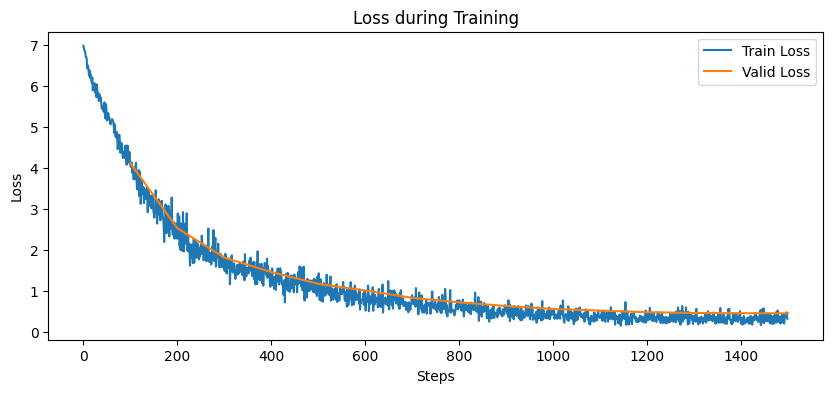

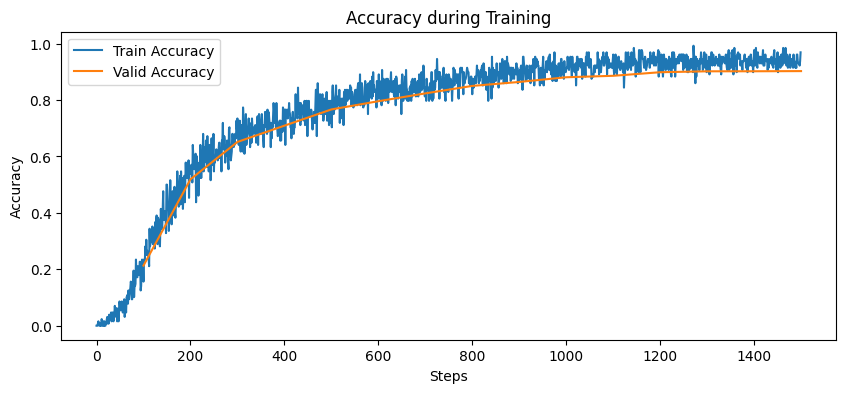

In [21]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
import numpy as np


def main(
    emg_dir,
    imu_dir,
    save_path,
    batch_size,
    n_workers,
    valid_steps,
    warmup_steps,
    total_steps,
    save_steps,
    pretrained_path=None,
    early_stop=5,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Info]: Use {device} now!")

    train_loader, valid_loader, test_loader, num_classes = get_fused_dataloader(
        emg_dir, imu_dir, batch_size, n_workers
    )
    print(f"[Info]: Finish loading data!", flush=True)

    #     model = SignLanguageModel(num_classes=num_classes).to(device)
    model = SignLanguageModelWithLSTM(num_classes=num_classes).to(device)

    if pretrained_path:
        model.load_state_dict(torch.load(pretrained_path, map_location=device))
        print("[Info]: Pretrained model loaded!")

    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=1e-3 * 4)
    #     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    best_accuracy = -1.0
    best_state_dict = None
    no_improve_epochs = 0  # Count epochs with no improvement

    pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

    for step in range(total_steps):
        try:
            batch = next(iter(train_loader))
        except StopIteration:
            train_iterator = iter(train_loader)
            batch = next(train_iterator)

        loss, accuracy = model_fn(batch, model, criterion, device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Store metrics
        train_losses.append(loss.item())
        train_accuracies.append(accuracy.item())

        pbar.update()
        pbar.set_postfix(
            loss=f"{loss.item():.2f}",
            accuracy=f"{accuracy:.2f}",
            step=step + 1,
        )

        if (step + 1) % valid_steps == 0:
            pbar.close()
            valid_loss, valid_accuracy = valid(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)
            valid_accuracies.append(valid_accuracy)

            if valid_accuracy > best_accuracy:
                best_accuracy = valid_accuracy
                best_state_dict = model.state_dict()
                no_improve_epochs = 0  # Reset counter
            else:
                no_improve_epochs += 1

            if no_improve_epochs >= early_stop:
                print(
                    "Early stopping triggered due to no improvement in validation accuracy."
                )
                break  # Break the loop if no improvement in the last 'early_stop' epochs

            pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

        if (step + 1) % save_steps == 0 and best_state_dict is not None:
            torch.save(best_state_dict, save_path + "/" + "model.ckpt")
            print(f"Step {step + 1}, best model saved. (accuracy={best_accuracy:.4f})")

    pbar.close()

    # Plot and save loss
    plt.figure(figsize=(10, 4))
    #     plt.plot(np.arange(len(train_losses)) * valid_steps, train_losses, label='Train Loss')
    plt.plot(train_losses, label="Train Loss")
    plt.plot(
        np.arange(1, len(valid_accuracies) + 1) * valid_steps,
        valid_losses,
        label="Valid Loss",
    )
    plt.title("Loss during Training")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(save_path + "/loss_plot.png")
    plt.show()

    # Plot and save accuracy
    plt.figure(figsize=(10, 4))
    #     plt.plot(np.arange(len(train_accuracies)) * valid_steps, train_accuracies, label='Train Accuracy')
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(
        np.arange(1, len(valid_accuracies) + 1) * valid_steps,
        valid_accuracies,
        label="Valid Accuracy",
    )
    plt.title("Accuracy during Training")
    plt.xlabel("Steps")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(save_path + "/accuracy_plot.png")
    plt.show()

    # Save metrics to files
    np.savetxt(save_path + "/train_losses.txt", np.array(train_losses))
    np.savetxt(save_path + "/train_accuracies.txt", np.array(train_accuracies))
    np.savetxt(save_path + "/valid_losses.txt", np.array(valid_losses))
    np.savetxt(save_path + "/valid_accuracies.txt", np.array(valid_accuracies))


def parse_args():
    """arguments"""
    config = {
        # "data_dir": "./emg_data",
        # "data_dir": "/tmp/dataset/emg_data/emg_data",
        # "emg_dir": "/tmp/dataset/emg_data/emg_data",
        # "imu_dir": "/tmp/dataset/imu_data/imu_data",
        "emg_dir": emg_data_path,
        "imu_dir": imu_data_path,
        "save_path": "./result",
        "batch_size": 128,
        "n_workers": 8,
        "valid_steps": 100,
        "warmup_steps": 500,
        "save_steps": 100,
        "total_steps": 500,
        "early_stop": 10,
        "pretrained_path": None,
        #         "pretrained_path": "./result/model.ckpt",
        #         "pretrained_path": "model-pretrained-0.9185.ckpt",  # 可以设置为预先训练好的模型路径
    }
    return config


if __name__ == "__main__":
    main(**parse_args())

# Inference

## Dataset of inference

## Main function of Inference

In [15]:
import torch
import numpy as np
import time
import pandas as pd
import platform

# import pickle


def inference(test_loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []
    start_time = time.time()

    with torch.no_grad():
        for batch in test_loader:
            emg_data, imu_data, labels = batch
            emg_data = emg_data.to(device)
            imu_data = imu_data.to(device)
            labels = labels.to(device)

            outputs = model(emg_data, imu_data)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    end_time = time.time()
    inference_time = end_time - start_time
    return np.array(all_preds), np.array(all_labels), inference_time


def parse_args():
    """arguments"""
    config = {
        # "data_dir": "./emg_data",
        # "data_dir": "/tmp/dataset/emg_data/emg_data",
        # "emg_dir": "/tmp/dataset/emg_data/emg_data",
        # "imu_dir": "/tmp/dataset/imu_data/imu_data",
        "emg_dir": emg_data_path,
        "imu_dir": imu_data_path,
        "save_path": "./result",
        "batch_size": 128,
        "n_workers": 8,
        "valid_steps": 500,
        "warmup_steps": 500,
        "save_steps": 500,
        "total_steps": 1500,
        "early_stop": 6,
        #         "pretrained_path": "model-lstm-0.9496.ckpt",
        "pretrained_path": "./result/model.ckpt",
        #         "pretrained_path": "model-pretrained-0.8001.ckpt",
        #         "pretrained_path": "model-pretrained-0.9185.ckpt",  # 可以设置为预先训练好的模型路径
    }
    return config


if __name__ == "__main__":
    config = parse_args()
    train_loader, valid_loader, test_loader, num_classes = get_fused_dataloader(
        config["emg_dir"],
        config["imu_dir"],
        config["batch_size"],
        config["n_workers"],
        random_state=42,
        fix_val_seed=False,
    )

    # 打印测试集的基本信息
    print(f"Number of samples in test set: {len(test_loader.dataset)}")
    print(f"Number of classes in test set: {num_classes}")

    # 加载模型
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SignLanguageModelWithLSTM(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load(config["pretrained_path"], map_location=device))
    print("[Info]: Pretrained model loaded!")

    # 在测试集上进行推理并记录时间
    preds, labels, inference_time = inference(test_loader, model, device)
    print(f"Test set predictions: {preds}")
    print(f"Test set labels: {labels}")
    print(f"Inference time: {inference_time:.2f} seconds")
    print(f"Device used for inference: {device}")

    # 计算测试集准确率
    test_accuracy = (preds == labels).mean()
    print(f"Test set accuracy: {test_accuracy:.4f}")

    # 保存测试集及分类结果为CSV文件
    save_path = config["save_path"]
    results = {"prediction": preds, "label": labels}
    df = pd.DataFrame(results)
    df.to_csv(save_path + "/test_results.csv", index=False)
    print("[Info]: Test results saved to 'test_results.csv'")

    # 保存推理时间和设备信息到文本文件
    with open(save_path + "/inference_info.txt", "w") as f:
        f.write(f"Device: {device}\n")
        f.write(f"Inference time: {inference_time:.2f} seconds\n")
        f.write(f"Accuracy: {test_accuracy:.4f}\n")
        f.write(f"Platform: {platform.platform()}\n")
    print("[Info]: Inference info saved to 'inference_info.txt'")

#     # 保存推理时间和设备信息
#     system_info = {
#         'device': str(device),
#         'inference_time': inference_time,
#         'accuracy': test_accuracy,
#         'platform': platform.platform()
#     }
#     df_info = pd.DataFrame([system_info])
#     df_info.to_csv(save_path + '/inference_info.csv', index=False)
#     print("[Info]: Inference info saved to 'inference_info.csv'")


# # 保存测试集及分类结果
# save_path = config['save_path']
# with open(save_path + '/test_results.pkl', 'wb') as f:
#     pickle.dump({'predictions': preds, 'labels': labels}, f)
# print("[Info]: Test results saved to 'test_results.pkl'")

Number of samples in test set: 7609
Number of classes in test set: 1059
[Info]: Pretrained model loaded!
Test set predictions: [   0    2    7 ... 1054 1053 1054]
Test set labels: [   0    1    2 ... 1054 1054 1054]
Inference time: 6.16 seconds
Device used for inference: cuda
Test set accuracy: 0.9482
[Info]: Test results saved to 'test_results.csv'
[Info]: Inference info saved to 'inference_info.txt'


In [1]:
import matplotlib.pyplot as plt

In [13]:
import numpy as np

# Load train losses, train accuracies, valid losses, and valid accuracies
train_losses_warmup = np.loadtxt("训练结果/lstm-repeatIMU-1500steps-again/train_losses.txt")
train_accuracies_warmup = np.loadtxt("训练结果/lstm-repeatIMU-1500steps-again/train_accuracies.txt")
valid_losses_warmup = np.loadtxt("训练结果/lstm-repeatIMU-1500steps-again/valid_losses.txt")
valid_accuracies_warmup = np.loadtxt("训练结果/lstm-repeatIMU-1500steps-again/valid_accuracies.txt")

train_losses = np.loadtxt("训练结果/lstm-repeatIMU-1500steps/train_losses.txt")
train_accuracies = np.loadtxt("训练结果/lstm-repeatIMU-1500steps/train_accuracies.txt")
valid_losses = np.loadtxt("训练结果/lstm-repeatIMU-1500steps/valid_losses.txt")
valid_accuracies = np.loadtxt("训练结果/lstm-repeatIMU-1500steps/valid_accuracies.txt")


In [14]:
valid_accuracies

array([0.21300118, 0.51872052, 0.65123821, 0.70887382, 0.76636203,
       0.79554835, 0.82326061, 0.84979363, 0.86379717, 0.88045401,
       0.88561321, 0.89829009, 0.90153302, 0.90168042, 0.90227005])

In [10]:
valid_steps = 100
save_path = "训练结果/lstm-repeatIMU-1500steps-again"



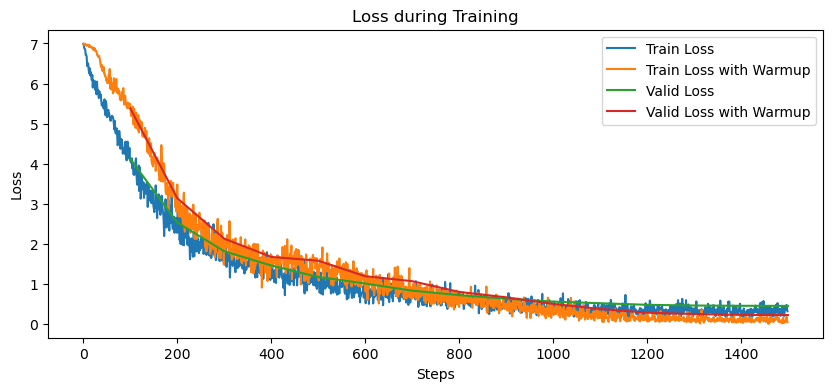

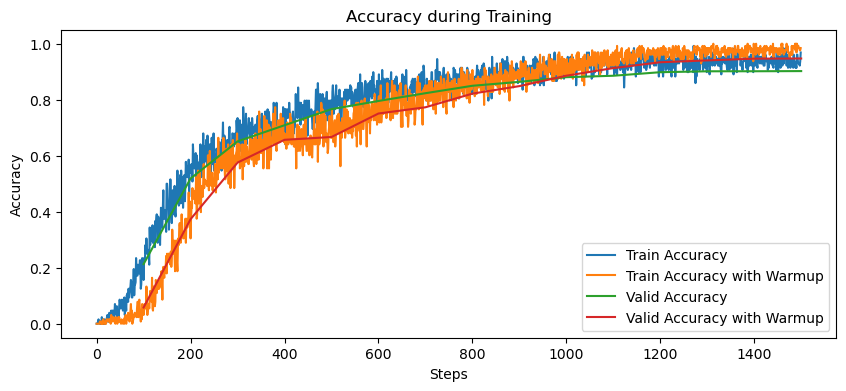

In [15]:

# Plot and save loss
plt.figure(figsize=(10, 4))
#    plt.plot(np.arange(len(train_losses)) * valid_steps, train_losses, label='Train Loss')
plt.plot(train_losses, label='Train Loss')
plt.plot(train_losses_warmup, label='Train Loss with Warmup')
plt.plot(np.arange(1, len(valid_accuracies) + 1) * valid_steps, valid_losses, label='Valid Loss')
plt.plot(np.arange(1, len(valid_accuracies) + 1) * valid_steps, valid_losses_warmup, label='Valid Loss with Warmup')
plt.title('Loss during Training')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.savefig(save_path + "/loss_plot_1.png")
plt.show()

 # Plot and save accuracy
plt.figure(figsize=(10, 4))
#    plt.plot(np.arange(len(train_accuracies)) * valid_steps, train_accuracies, label='Train Accuracy')
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(train_accuracies_warmup, label='Train Accuracy with Warmup')
plt.plot(np.arange(1, len(valid_accuracies) + 1) * valid_steps, valid_accuracies, label='Valid Accuracy')
plt.plot(np.arange(1, len(valid_accuracies) + 1) * valid_steps, valid_accuracies_warmup, label='Valid Accuracy with Warmup')
plt.title('Accuracy during Training')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(save_path + "/accuracy_plot_1.png")
plt.show()

In [25]:
    # 保存推理时间和设备信息到文本文件
    with open(save_path + '/inference_info.txt', 'w') as f:
        f.write(f"Device: {device}\n")
        f.write(f"Inference time: {inference_time:.2f} seconds\n")
        f.write(f"Accuracy: {test_accuracy:.4f}\n")
        f.write(f"Platform: {platform.platform()}\n")
    print("[Info]: Inference info saved to 'inference_info.txt'")

[Info]: Inference info saved to 'inference_info.txt'


In [19]:
print(f"Test set accuracy: {test_accuracy:.4f}")

Test set accuracy: 0.9677


In [16]:
    import pickle
    # 保存测试集及分类结果
    save_path = config['save_path']
    with open(save_path + '/test_results.pkl', 'wb') as f:
        pickle.dump({'predictions': preds, 'labels': labels}, f)
    print("[Info]: Test results saved to 'test_results.pkl'")

[Info]: Test results saved to 'test_results.pkl'


# some explainations

## combined_features = self.fusion_transformer(combined_features.unsqueeze(1)).squeeze(1)

1. combined_features.unsqueeze(1):
unsqueeze(1) 在 combined_features 的第一个维度（索引为1的位置）插入一个新的维度。
如果 combined_features 的原始形状是 [batch_size, feature_dim]，那么 unsqueeze(1) 后的形状将变为 [batch_size, 1, feature_dim]。
这通常是为了符合 TransformerEncoder 的输入要求，即输入需要是一个三维张量 [batch_size, seq_length, feature_dim]。
2. self.fusion_transformer(...):
self.fusion_transformer 是一个 TransformerEncoder 实例，用于处理融合后的特征。
它接受形状为 [batch_size, seq_length, feature_dim] 的输入，并返回相同形状的输出。
在这里，seq_length 是1，因为我们只插入了一个新的维度。
3. .squeeze(1):
squeeze(1) 移除第一个维度（索引为1的位置）中大小为1的维度。
如果 fusion_transformer 的输出形状是 [batch_size, 1, feature_dim]，那么 squeeze(1) 后的形状将变为 [batch_size, feature_dim]。
这一步是为了恢复原始的特征维度形状。
总结：
这段代码的作用是将 combined_features 通过 unsqueeze 转换为三维张量，传入 fusion_transformer 进行处理，然后通过 squeeze 恢复为二维张量。这样做的目的是为了符合 TransformerEncoder 的输入要求，并在处理后恢复原始形状。